# Programming Assignment I: Explainability

In this assignment you will train machine learning models and experiment with techniques discussed in the lectures.
This assignment makes use of existing Python libraries. We have provided links to tutorials/examples if you're not familiar with them yet.


All code that you write should be in this notebook. You should submit:
* This notebook with your code added. Make sure to add enough documentation.
* A short report, max 3 pages including any figures and/or tables. Use this [template](https://www.overleaf.com/read/mvskntycrckw).
* Zip the notebook .ipynb and report .pdf files in a file with name format 'Prog_Explainability_Group_[X].zip', where X is your programming group ID (e.g. Prog_Explainability_Group_10.zip). The .ipynb and .pdf files should also have the same name as the zip file.


Important notes:
* Deadline for this assignment is **Wednesday, May 18, 17:00**. 
* Send it to both Heysem Kaya (h.kaya@uu.nl) and Gizem Sogancioglu (g.sogancioglu@uu.nl), CCing your programming partner.
* Title of the email: [INFOMHCML] Explainability programming assignment submission [X], with X the number of your group.
* There will be a lab session to assist you with the assignment on **Thursday, May 12, between 13:15-15:00 at BOL 1.049 and BOL 1.051**.



## Installation

For this assignment, we are going to use the following Python packages:

matplotlib, pandas, statsmodels, interpret, scikit-learn, openpyxl and graphviz

In [ ]:
# Installing packages
!conda install python-graphviz
!pip install matplotlib pandas statsmodels interpret sklearn openpyxl
# Needed for PDP
!pip install scikit-learn --upgrade

/bin/bash: conda: command not found
     |████████████████████████████████| 6.6 MB 3.7 MB/s 
     |████████████████████████████████| 5.8 MB 24.2 MB/s 
     |████████████████████████████████| 3.6 MB 47.1 MB/s 
     |████████████████████████████████| 9.6 MB 24.0 MB/s 
     |████████████████████████████████| 280 kB 51.0 MB/s 
     |████████████████████████████████| 756 kB 57.9 MB/s 
     |████████████████████████████████| 564 kB 52.4 MB/s 
     |████████████████████████████████| 793 kB 56.6 MB/s 
     |████████████████████████████████| 131 kB 49.5 MB/s 
     |████████████████████████████████| 275 kB 69.8 MB/s 
     |████████████████████████████████| 251 kB 54.4 MB/s 
     |████████████████████████████████| 428 kB 45.9 MB/s 
     |████████████████████████████████| 130 kB 57.7 MB/s 
     |████████████████████████████████| 381 kB 61.5 MB/s 
     |████████████████████████████████| 81 kB 6.5 MB/s 
     |████████████████████████████████| 357 kB 54.4 MB/s 
     |████████████████████████████████|

## Downloading the data
We are going to use the combined cycle power plant dataset. This dataset contains 9568 data points collected from a Combined Cycle Power Plant over 6 years (2006-2011), when the power plant was set to work with full load. We have the following features: hourly average ambient variables Temperature (T), Ambient Pressure (AP), Relative Humidity (RH) and Exhaust Vacuum (V). We will train ML models to predict the net hourly electrical energy output (EP) of the plant.

For a detailed description, see: [[Description](https://archive.ics.uci.edu/ml/datasets/combined+cycle+power+plant)]

We first need to download and prepare data. 


In [ ]:
# Download and unzip data
!wget -c https://archive.ics.uci.edu/ml/machine-learning-databases/00294/CCPP.zip
!unzip CCPP.zip

--2022-04-27 10:37:45--  https://archive.ics.uci.edu/ml/machine-learning-databases/00294/CCPP.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3674852 (3.5M) [application/x-httpd-php]
Saving to: ‘CCPP.zip’

CCPP.zip            100%[===================>]   3.50M  3.37MB/s    in 1.0s    

2022-04-27 10:37:47 (3.37 MB/s) - ‘CCPP.zip’ saved [3674852/3674852]

Archive:  CCPP.zip
   creating: CCPP/
  inflating: CCPP/Folds5x2_pp.ods    
  inflating: CCPP/Folds5x2_pp.xlsx   
  inflating: CCPP/Readme.txt         
  inflating: CCPP/Readme.txt~        


## Loading and preprocessing the data
We split the data into training (first 5000 instances) and validation (the subsequent 2000) and test (the last 2568) sets. We will use the training set to train a model, and validation set to optimize the model hyper-parameters. 


In [ ]:
# Load and prepare data
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler

# global variables
DATA_FILENAME = 'CCPP/Folds5x2_pp.xlsx'
FEATURE_NAMES = ['AT', 'V', 'AP', 'RH']
LABEL_NAME = 'PE'
# Load the data from the excel file
def load_data():
    def split_feature_label(data_set):
        features = data_set[FEATURE_NAMES]
        labels = data_set[LABEL_NAME]
        return features, labels

    data = pd.read_excel(DATA_FILENAME)
    train_set, dev_set, test_set = data[:5000], data[5000: 7000], data[7000:]

    train_features, train_labels = split_feature_label(train_set)
    dev_features, dev_labels = split_feature_label(dev_set)
    test_features, test_labels = split_feature_label(test_set)

    return train_features, train_labels, dev_features, \
        dev_labels, test_features, test_labels


# preprocess (by z-normalization) the data for the regression task
# return the normalized feature sets and corresponding target variables 
def prepare_load_regression_data():
    train_features, train_labels, dev_features, \
        dev_labels, test_features, test_labels = load_data()

    scaler = StandardScaler()
    scaler = scaler.fit(train_features)
    train_features = pd.DataFrame(data=scaler.transform(train_features), columns=FEATURE_NAMES)
    dev_features = pd.DataFrame(data=scaler.transform(dev_features), columns=FEATURE_NAMES)
    test_features = pd.DataFrame(data=scaler.transform(test_features), columns=FEATURE_NAMES)

    return train_features, train_labels, dev_features, \
        dev_labels, test_features, test_labels



## Training and Interpreting a Linear Regression Model

**Q1**. Train a linear regression model (we recommend the statsmodels package) and report $R^2$ (goodness of fit) statistic. 

For model interpretability, provide for each feature (+ the bias variable) the following in tabular format: 
* Weight estimates
* SE (standard error of estimates) 
* T statistics 


Further Questions regarding the linear model (to be included in the report): 


In [ ]:
# We recommend the statsmodels package
import statsmodels.api as sm
import statsmodels.formula.api as smf
# Linear regression
train_features, train_labels, dev_features, dev_labels, test_features, test_labels = prepare_load_regression_data()
lr_model = smf.ols(f"{LABEL_NAME} ~ AT+V+AP+RH", data=train_features.join(train_labels))
lr_model_fit = lr_model.fit()
print(lr_model_fit.summary())

                            OLS Regression Results                            
Dep. Variable:                     PE   R-squared:                       0.929
Model:                            OLS   Adj. R-squared:                  0.929
Method:                 Least Squares   F-statistic:                 1.644e+04
Date:                Wed, 27 Apr 2022   Prob (F-statistic):               0.00
Time:                        10:38:34   Log-Likelihood:                -14635.
No. Observations:                5000   AIC:                         2.928e+04
Df Residuals:                    4995   BIC:                         2.931e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    454.4443      0.064   7108.416      0.0

In [ ]:
import io
results_df = pd.read_csv(io.StringIO(lr_model_fit.summary().tables[1].as_csv()), index_col=0, header=0)
cap = "This table shows the regression results for a Linear Regression on the CCPP"
header = "Coefficients SE T P [2.5% 97.5%]".split()
print("")
print(
    results_df.to_latex(
        caption=cap,
        label=LABEL_NAME,
        header=header,
        float_format="%.3f",
    ).replace("{tabular}", "{tabular}"))


\begin{table}
\centering
\caption{This table shows the regression results for a Linear Regression on the CCPP}
\label{PE}
\begin{tabular}{lrrrrrr}
\toprule
{} & Coefficients &    SE &        T &     P &   [2.5\% &  97.5\%] \\
          &              &       &          &       &         &         \\
\midrule
Intercept &      454.444 & 0.064 & 7108.416 & 0.000 & 454.319 & 454.570 \\
AT        &      -14.808 & 0.156 &  -95.152 & 0.000 & -15.113 & -14.503 \\
V         &       -2.853 & 0.127 &  -22.543 & 0.000 &  -3.102 &  -2.605 \\
AP        &        0.382 & 0.077 &    4.948 & 0.000 &   0.231 &   0.533 \\
RH        &       -2.425 & 0.083 &  -29.185 & 0.000 &  -2.588 &  -2.262 \\
\bottomrule
\end{tabular}
\end{table}



**Q2**. Which three features are the most important?


The order(big to small) of the absolute value of Coefficients should be AT(|-14.8080|) > V(|-2.8534|) > RH(|-2.4247|) > AP(0.3820) and the order of the absolute value of T should be AT(|-95.152|) > RH(|-29.185|) > V(|-22.543|) >  AP(4.948). So, the top three most important features should be Ambient Temperature (AT), Exhaust Vacuum (V), Relative Humidity (RH)

**Q3**. How does the gas turbine energy yield (EP) change with unit (one degree C) increase of the ambient temperature given that all other feature values remain the same? (Note: Here you should consider whether you use the original or z-normalized features to train your linear model.)


In [ ]:
# if we use the original features
# used AT: 14.96,   V: 41.76,   AP: 1024.07,  RH: 73.17
# now AT: 15.96,   V: 41.76,   AP: 1024.07,  RH: 73.17
train_features, train_labels, dev_features, dev_labels, test_features, test_labels = load_data()
lr_model_2 = smf.ols(f"{LABEL_NAME} ~ AT+V+AP+RH", data=train_features.join(train_labels))
lr_model_fit_2 = lr_model_2.fit()
print(lr_model_fit_2.summary())
x_1={'AT':[14.96], 'V':[41.76], 'AP':[1024.07], 'RH':[73.17]}
print(lr_model_fit_2.predict(pd.DataFrame(x_1)))
x_2={'AT':[15.96], 'V':[41.76], 'AP':[1024.07], 'RH':[73.17]}
print(lr_model_fit_2.predict(pd.DataFrame(x_2)))
print(train_labels[0])
# if we use the z-normalized features
# used AT: -0.628341, V: -0.983949, AP: 1.821724, RH: -0.002553
# now AT: -0.493323, V: -0.983949, AP: 1.821724, RH: -0.002553
train_features, train_labels, dev_features, dev_labels, test_features, test_labels = prepare_load_regression_data()
lr_model = smf.ols(f"{LABEL_NAME} ~ AT+V+AP+RH", data=train_features.join(train_labels))
lr_model_fit = lr_model.fit()
print(lr_model_fit.summary())
x_3={'AT':[-0.628341], 'V':[-0.983949], 'AP':[1.821724], 'RH':[-0.002553]}
print(lr_model_fit.predict(pd.DataFrame(x_3)))
x_4={'AT':[-0.493323], 'V':[-0.983949], 'AP':[1.821724], 'RH':[-0.002553]}
print(lr_model_fit.predict(pd.DataFrame(x_4)))
print(train_labels[0])

                            OLS Regression Results                            
Dep. Variable:                     PE   R-squared:                       0.929
Model:                            OLS   Adj. R-squared:                  0.929
Method:                 Least Squares   F-statistic:                 1.644e+04
Date:                Tue, 26 Apr 2022   Prob (F-statistic):               0.00
Time:                        11:18:33   Log-Likelihood:                -14635.
No. Observations:                5000   AIC:                         2.928e+04
Df Residuals:                    4995   BIC:                         2.931e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    452.6467     13.455     33.641      0.0

If we use the original features to train our linear model, we use the data in the first row as an example, the real value of EP should be 463.26, we use the used value(AT: 14.96, V: 41.76, AP: 1024.07, RH: 73.17) and adjusted value(AT: 15.96, V, AP, RH remain the same) to calculate the EP. The first value is 467.258525 while the second value is 465.258668. The decrease value between two EPs matches the absolute value of coefficients of AT.

If we use the z-normalized features to train our linear model, we also use the data in the first row as an example, the real value of EP should be 463.26, we use the used value(AT: -0.628341, V: -0.983949, AP: 1.821724, RH: -0.002553) and adjusted value(AT: -0.493323, V, AP, RH remain the same) to calculate the EP. The first value is also 467.258525 while the second value is still 465.258668. The decrease value is the same as previous model and it is also the same as the the absolute value of coefficients multiply the differences of two ATs.

**Q4**. Visualize the weight estimates using 95% confidence intervals.

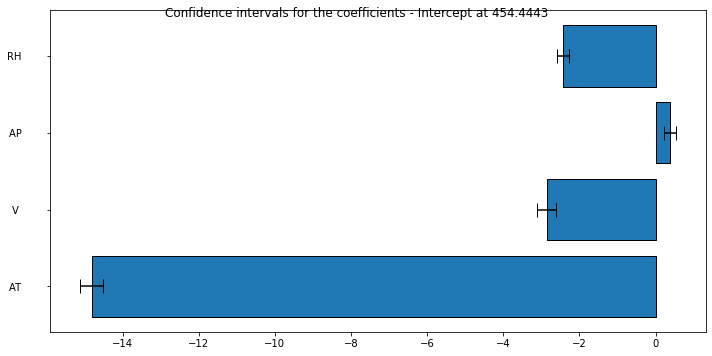

In [ ]:
import matplotlib.pyplot as plt
offset = 1
barWidth = .5
coeff_values = results_df.iloc[offset:, 0]
lower_bound = results_df.iloc[offset:, 4]
upper_bound = results_df.iloc[offset:, 5]
label_names = coeff_values.keys()
bar_position = list(range(len(coeff_values)))
cnf_intvs = (upper_bound - lower_bound) / 2

fig = plt.figure(figsize=(10, 5))
ax = plt.gca()
ax.barh(
    bar_position,
    coeff_values,
    edgecolor='black',
    xerr=cnf_intvs,
    capsize=7,
)
ax.set_yticks([r for r in bar_position])
ax.set_yticklabels(label_names)
fig.suptitle(f"Confidence intervals for the coefficients - Intercept at {results_df.iloc[0, 0]}")
fig.tight_layout()
plt.savefig("confidence_intervalls.png")
plt.show()

**Q5**. Show bar graph illustrations of the feature effects for the first two validation set instances.

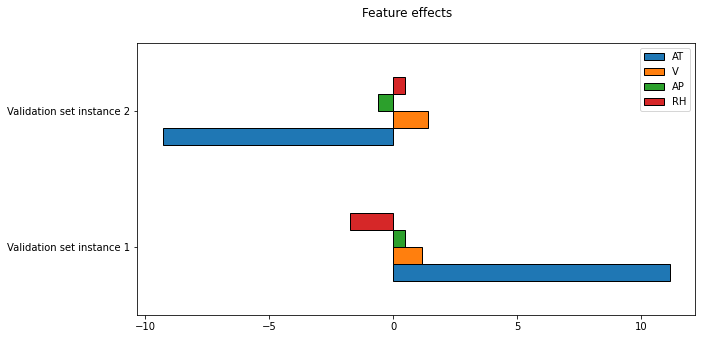

In [ ]:
index = ["Validation set instance 1", "Validation set instance 2"]
cols = dev_features[:2].columns
FE_tmp = dev_features[:2].values * results_df.iloc[1:, 0].values
FE = pd.DataFrame(FE_tmp, columns=cols, index=index)
fig = plt.figure(figsize=(10, 5))
ax = plt.gca()
FE.plot.barh(
    ax=ax,
    edgecolor='black',
    capsize=7,
)
fig.suptitle("Feature effects")
plt.savefig("feature_effects.png")
plt.show()

**Q6.** Reflection: why would training a regression tree not work well for this dataset?

Too many data in this dataset and there is no regular law on this dataset. Regression tree will easily make one data link to one situation in its algorithm  and this can easily cause overfit problem. 

In addition, this data set is more linearly distributed, in which the predicted values of the regression tree cannot be smoothed as in linear regression, so linear regression is more suitable than regression tree in this case.

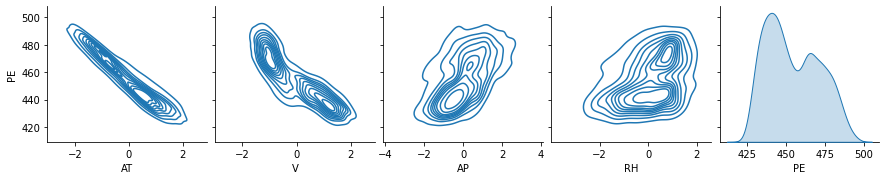

In [ ]:
import seaborn as sns
sns.pairplot(data=train_features.join(train_labels), kind="kde", y_vars=["PE"])
plt.savefig("kde.png")
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/regression.py:592: UserWarning: sharex is deprecated from the `lmplot` function signature. Please update your code to pass it using `facet_kws`.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/regression.py:592: UserWarning: sharey is deprecated from the `lmplot` function signature. Please update your code to pass it using `facet_kws`.
  warnings.warn(msg, UserWarning)


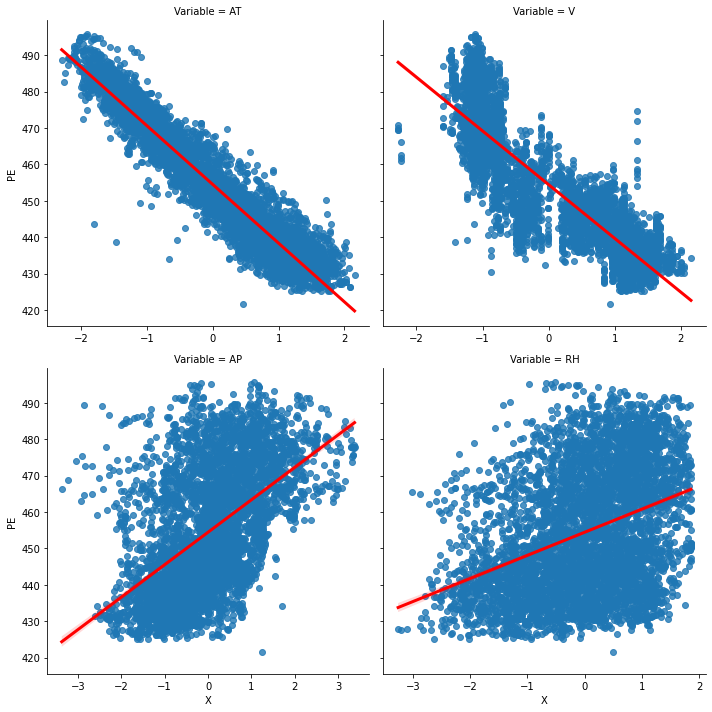

In [ ]:
import seaborn as sns
plotting_data = train_features.join(train_labels)
plotting_data_melted = plotting_data.melt(id_vars="PE",value_vars="AT V AP RH".split(),var_name="Variable",value_name="X")
sns.lmplot(
    x='X',
    y='PE',
    col='Variable',  
    data=plotting_data_melted,
    col_wrap=2, 
    sharex=False,
    sharey=True,  
    line_kws={'color': 'red', "linewidth":3} 
)
plt.savefig("reg.png")
plt.show()

## Training and Interpreting an Explainable Boosting Model (Generalized Additive Model)
**Q7**. Train a Explainable Boosting Machine (with [interpret.ml](https://github.com/interpretml/interpret/))

For a tutorial see: [[Tutorial](https://nbviewer.jupyter.org/github/interpretml/interpret/blob/master/examples/python/notebooks/Interpretable%20Classification%20Methods.ipynb)]


* Report global (model-wise) feature importances for EBM as a table or figure. What are the most important two features in EBM? Are they the same as in the linear model? 
* Report local (instance-wise) feature importances for a development set instance of your choice.


In [ ]:
from interpret.glassbox import ExplainableBoostingRegressor
from interpret import show
train_features, train_labels, dev_features, dev_labels, test_features, test_labels = prepare_load_regression_data()
ebm = ExplainableBoostingRegressor()
ebm.fit(train_features, train_labels)
# EBM

ExplainableBoostingRegressor(feature_names=['AT', 'V', 'AP', 'RH', 'V x AP',
                                            'AT x AP', 'V x RH', 'AP x RH',
                                            'AT x V', 'AT x RH'],
                             feature_types=['continuous', 'continuous',
                                            'continuous', 'continuous',
                                            'interaction', 'interaction',
                                            'interaction', 'interaction',
                                            'interaction', 'interaction'])

In [ ]:
ebm_global = ebm.explain_global(name='EBM')
show(ebm_global)

/usr/local/lib/python3.7/dist-packages/interpret/provider/visualize.py:44: UserWarning: Cloud environment detected (['colab', 'ipython']): viz integration is still experimental.
  detected_envs


In [ ]:
ebm_local = ebm.explain_local(dev_features[:5], dev_labels[:5], name='EBM')
show(ebm_local)

In [ ]:
from interpret.perf import RegressionPerf
ebm_perf = RegressionPerf(ebm.predict).explain_perf(dev_features, dev_labels, name='EBM')
show(ebm_perf)

## Training and Explaining Neural Networks
**Q8**. Train a Neural Network (using the training and validation sets): One-layer MLP (ReLU activation function + 50 hidden neurons)

We recommend to use the Adam optimizer. Fine-tune the learning rate and any other hyper-parameters you find necessary. 

For a tutorial see: [[Tutorial](https://scikit-learn.org/stable/modules/neural_networks_supervised.html)]

Report the results following the instructions below:

* Apply the trained neural network model on the test set and report Root Mean Square Error (RMSE) and Spearman Rank Correlation as performance measures.

* Analyzing factors influencing the neural network predictions. 
See the [Documentation](https://scikit-learn.org/stable/modules/partial_dependence.html) to use Partial Dependence Plot (PDP) and Independent Conditional Expectation (ICE) implementations in python.
Use the trained one-layer MLP model to
  * Generate and report a bivariate PDP using 'AT' (Ambient Temperature) and 'V' (Exhaust Vacuum) features (Note: not two univariate PDPs but one bivariate PDP).
  * Generate and report ICE plots for each of the features.

In [ ]:
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error
from scipy.stats import spearmanr

# One-layer MLP
one_layer_nn = MLPRegressor(hidden_layer_sizes=(50, ), activation="relu", solver="adam", max_iter=500, learning_rate_init=0.01)
one_layer_nn.fit(train_features, train_labels)
test_preds = one_layer_nn.predict(test_features)
print(np.sqrt(mean_squared_error(test_labels, test_preds)))
rho, p = spearmanr(test_labels, test_preds)
print(rho)

#dev_preds = one_layer_nn.predict(dev_features)
#print(np.sqrt(mean_squared_error(dev_labels, dev_preds)))
#rho, p = spearmanr(dev_labels, dev_preds)
#print(rho)

4.435487036921619
0.9607434212575287


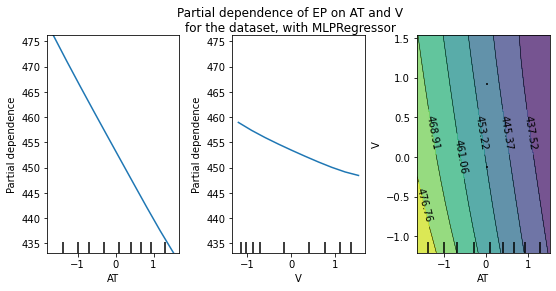

In [ ]:
from sklearn.inspection import partial_dependence
from sklearn.inspection import PartialDependenceDisplay
features = ["AT", "V", ("AT", "V")]
_, ax = plt.subplots(ncols=3, figsize=(9, 4))
display = PartialDependenceDisplay.from_estimator(
    one_layer_nn,
    train_features,
    features,
    kind="average",
    n_jobs=2,
    grid_resolution=10,
    ax=ax,
)
display.figure_.suptitle(
    "Partial dependence of EP on AT and V\n"
    "for the dataset, with MLPRegressor"
)
display.figure_.subplots_adjust(wspace=0.4, hspace=0.3)
#features = [0, 1, (0, 1)]
#PartialDependenceDisplay.from_estimator(one_layer_nn, train_features, features, target=0)

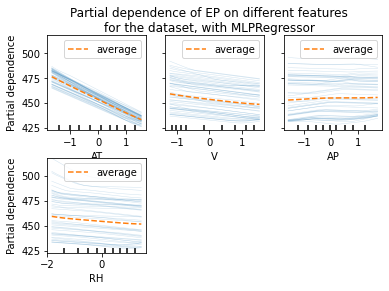

In [ ]:
features = ["AT", "V", "AP", "RH"]
display = PartialDependenceDisplay.from_estimator(
    one_layer_nn,
    train_features,
    features,
    kind="both",
    subsample=50,
    n_jobs=3,
    grid_resolution=20,
    random_state=0,
    ice_lines_kw={"color": "tab:blue", "alpha": 0.2, "linewidth": 0.5},
    pd_line_kw={"color": "tab:orange", "linestyle": "--"},
)
display.figure_.suptitle(
    "Partial dependence of EP on different features\n"
    "for the dataset, with MLPRegressor"
)
display.figure_.subplots_adjust(hspace=0.3)
#features = [0, 1, 2, 3]
#PartialDependenceDisplay.from_estimator(one_layer_nn, train_features, features, kind='individual')

### Generating Model-Agnostic Explanations for NN predictions
You can check the tutorials for SHAP and LIME explanations for neural networks 
[[SHAP Tutorial](https://nbviewer.jupyter.org/github/interpretml/interpret/blob/master/examples/python/notebooks/Explaining%20Blackbox%20Classifiers.ipynb)] 
[[LIME Tutorial](https://nbviewer.jupyter.org/github/interpretml/interpret/blob/master/examples/python/notebooks/Explaining%20Blackbox%20Classifiers.ipynb)]


**Q9**. Provide explanations for two randomly selected test set instances using two explanation methods (LIME and SHAP) for the trained NN model. Thus report 2 x 2 = 4 explanations in total.

In [ ]:
# Global explanations
import graphviz
from interpret import show, preserve

# Local explanations (SHAP and LIME)
from interpret.blackbox import LimeTabular
from interpret.blackbox import ShapKernel
import random
np.random.seed(42)
indices_to_pick = np.random.randint(0, len(test_features), 2)
feature_names = list(train_features.columns)
background_val = np.median(train_features, axis=0).reshape(1, -1)
print(f"Picked indices: {indices_to_pick}")
x_Q9, y_Q9 = test_features.iloc[indices_to_pick], test_labels.iloc[indices_to_pick]
print(x_Q9)
print(y_Q9)

Picked indices: [ 860 1294]
            AT         V        AP        RH
860   0.927466  0.970409 -0.285144 -1.468322
1294 -1.200965 -1.174022  0.347255  0.911226
7860    438.87
8294    480.18
Name: PE, dtype: float64


In [ ]:
lime = LimeTabular(predict_fn=one_layer_nn.predict, data=train_features, random_state=1)
lime_local = lime.explain_local(x_Q9, y_Q9, name='LIME')
show(lime_local)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/interpret/provider/visualize.py:44: UserWarning: Cloud environment detected (['colab', 'ipython']): viz integration is still experimental.
  detected_env

In [ ]:
shap = ShapKernel(predict_fn = one_layer_nn.predict, data = background_val, feature_names = feature_names)
shap_local = shap.explain_local(x_Q9, y_Q9, name='SHAP')
show(shap_local)

X does not have valid feature names, but MLPRegressor was fitted with feature names
X does not have valid feature names, but MLPRegressor was fitted with feature names


  0%|          | 0/2 [00:00<?, ?it/s]

X does not have valid feature names, but MLPRegressor was fitted with feature names
X does not have valid feature names, but MLPRegressor was fitted with feature names
X does not have valid feature names, but MLPRegressor was fitted with feature names
X does not have valid feature names, but MLPRegressor was fitted with feature names
X does not have valid feature names, but MLPRegressor was fitted with feature names


In [ ]:
show(shap_local)